In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
# Load waypoints
file_name = "CP_C_F_CCW_1"
# output_dir = f"/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Vertical Line/{file_name}"
output_dir = f"/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Circular Path/{file_name}"
data_path = os.path.join(output_dir, "pose_waypoints_sampled_10hz_clean.csv")
data_path_2 = os.path.join(output_dir, "pose_waypoints_sampled_2.5hz_clean.csv")
plot_2 = False

# data_path = os.path.join(output_dir, "pose_waypoints_full.csv")

In [3]:
# Parse ground truth data
ground_truth = []
ground_truth_2 = []

# Read the CSV file with a header
with open(data_path, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])

# Read the CSV file with a header
with open(data_path_2, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth_2.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
        
gt_array = np.array(ground_truth)
gt_array_2 = np.array(ground_truth_2)

In [4]:
len(gt_array)

69

In [5]:
## Prediction function, for later
pred_model = 'CV'

# Make an empty dataframe to store the error values in next steps
results_df = pd.DataFrame()

# # Read the saved CSV file back into a DataFrame
# results_df = pd.read_csv("results_df.csv")

# # Display the loaded DataFrame
# results_df

In [6]:
## Prediction

# Group data by pedestrian ID (column 1)
pedestrian_ids = np.unique(gt_array[:, 1])
predictions = {}

ph = 1

for ped_id in pedestrian_ids:
    # Filter data for the current pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    
    # Initialize predictions for this pedestrian
    ped_predictions = []
    
    for i in range(0, len(ped_data) - 1 - ph):
        # Extract current and next timestep data
        t1, x1, y1 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
        t2, x2, y2 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
        
        # Calculate velocity (vx, vy)
        vx = (x2 - x1) / (t2 - t1)
        vy = (y2 - y1) / (t2 - t1)

        ### PREDICTION PART ###
        
        # Predict next position assuming constant velocity
        t_next = t2 + ph * (t2 - t1)  # Assuming uniform timestep
        x_next = x2 + vx * ph * (t2 - t1)
        y_next = y2 + vy * ph * (t2 - t1)
        
        # Store the prediction
        ped_predictions.append([t_next, ped_id, x_next, y_next])

    # Store predictions for this pedestrian
    predictions[ped_id] = ped_predictions

p_x = []
p_y = []
# Print predictions for each pedestrian
for ped_id, pred in predictions.items():
    # print(f"Predictions for pedestrian {ped_id}:")
    for p in pred:
        # print(p)
        p_x.append(p[2])
        p_y.append(p[3])

# len(p_x)

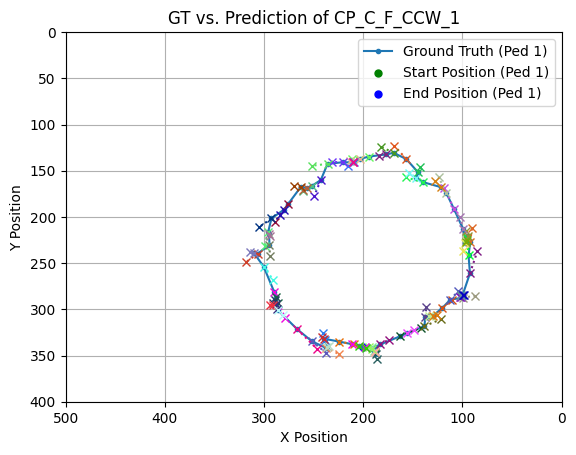

In [7]:
# # Assuming `data_array` and `predictions` are already computed as in the previous code

# # Extract x and y limits for the plot
# x_min, x_max = np.min(data_array[:, 2]), np.max(data_array[:, 2])
# y_min, y_max = np.min(data_array[:, 3]), np.max(data_array[:, 3])

# # Create the combined plot
# plt.figure(figsize=((x_max - x_min) * 0.5, (y_max - y_min) * 0.5), dpi=300)

# Set the x and y axis limits
plt.xlim(0, 500)
plt.ylim(0, 400)

pedestrian_ids = np.unique(gt_array[:, 1])

# Plot ground truth trajectory (blue)
for ped_id in pedestrian_ids:
    # Filter ground truth data for the pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    ped_data_2 = gt_array_2[gt_array_2[:, 1] == ped_id]

    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    x_gt_2, y_gt_2 = ped_data_2[:, 2], ped_data_2[:, 3]
    
    # Plot ground truth trajectory
    plt.plot(x_gt, y_gt, marker="o", linestyle="-", markersize=3,
             label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)
    
    if plot_2:
        plt.plot(x_gt_2, y_gt_2, marker="*", linestyle="-", markersize=3,
            label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)

    ## Plot predicted trajectory

    # Connect ground truth to prediction

    if ped_id in predictions:
        j = 1
        for pred in predictions[ped_id]:
            t_pred, ped_id_pred, x_pred, y_pred = pred
            
            plt.plot([x_gt[j], x_pred], [y_gt[j], y_pred], color=np.random.rand(3,),
                     marker="x", linestyle='dotted')
            j += 1

            # Othe types of plots can be added here, but be careful about multiple labels. It's better for the multi-step predictions, I think


    
    # plt.plot(p_x, p_y, marker="x", linewidth=1, linestyle='--', label='Predicted Positions', color="red") # Connect all prediction to each other
    # plt.scatter(p_x, p_y, marker="x", label='Predicted Positions', color="red") # Just show the predicted positions

# Mark start and end positions
for ped_id in np.unique(gt_array[:, 1]):
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    plt.scatter(x_gt[0], y_gt[0], color="green", s=25, label=f"Start Position (Ped {int(ped_id)})")
    plt.scatter(x_gt[-1], y_gt[-1], color="blue", s=25, label=f"End Position (Ped {int(ped_id)})")
    
plt.gca().invert_yaxis()  # Invert Y to match video coordinates
plt.gca().invert_xaxis()  # Invert X to match video coordinates

# Titles and labels
plt.title(f"GT vs. Prediction of {file_name}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
plt.close()

In [8]:
error_ade = []
error_ade_normal = []

# Calculate ADE
i = 0
for _, _, x, y in ground_truth[1+ph:]:
        pred = np.array((p_x[i], p_y[i]))
        gt = np.array((x, y))

        dist = np.linalg.norm(pred - gt, axis=-1)
        error_ade.append(dist)

        # In case of multe-step ahead prediction, all intermediate step sizes all considered. Another option is just to consider the direct distance to from origin gt to the prediction's corresponding gt, which is not considered here.

        steps_size = 0
        for j in range(1, ph + 1):
            step_start = np.array((ground_truth[i + j][2], ground_truth[i + j][3]))
            step_end = np.array((ground_truth[i + j + 1][2], ground_truth[i + j + 1][3]))

            steps_size += np.linalg.norm(step_end - step_start, axis=-1)

        # step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
        # step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))
        # step_size = np.linalg.norm(step_end - step_start, axis=-1)

        error_ade_normal.append(dist / steps_size)
        
        i += 1

ade_avg = np.average(error_ade)
print('Average prediction error: {:.2f}'.format(ade_avg))

ade_avg_normal = np.average(error_ade_normal)
print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

Average prediction error: 10.12
Average prediction error normalized: 1.70


In [9]:
# # Define file names and data paths
# file_names = ["DL_C_F_BRTL_1", "DL_C_F_BRTL_2", "DL_C_F_BRTL_3", "DL_C_F_BRTL_4", "DL_C_F_BRTL_5", "DL_C_F_BRTL_6"]
# data_files = ["pose_waypoints_sampled_10hz_clean.csv", "pose_waypoints_sampled_2.5hz_clean.csv", "pose_waypoints_full_clean.csv"]

# Directory for datasets
base_dir = "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Horizontal Line"
# base_dir = "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Circular Path"

# Placeholder for results
results = []

# Loop through file names and data files
for root, dirs, files in os.walk(base_dir):

    dataset_name = root.split("/")[-1]
    if dataset_name.startswith('x_'):
        continue

    for file in files:

        if file.endswith("_raw.csv") or file.endswith("_2.5hz_clean.csv"): ## REMEMBER TO EXCLUSE THE 2.5hz DATASET FOR HIGHER PH
            continue
        
        data_path = os.path.join(root, file)

        # Load data and calculate prediction error
        try:
            # Parse ground truth data
            ground_truth = []

            # Read the CSV file with a header
            with open(data_path, "r") as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
                    
            gt_array = np.array(ground_truth)

            # Group data by pedestrian ID (column 1)
            pedestrian_ids = np.unique(gt_array[:, 1])
            predictions = {}

            for ped_id in pedestrian_ids:
                # Filter data for the current pedestrian
                ped_data = gt_array[gt_array[:, 1] == ped_id]
                
                # Initialize predictions for this pedestrian
                ped_predictions = []

                ph = 1
                
                for i in range(0, len(ped_data) - 1 - ph):
                    # Extract current and next timestep data
                    t1, x1, y1 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
                    t2, x2, y2 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
                    
                    # Calculate velocity (vx, vy)
                    vx = (x2 - x1) / (t2 - t1)
                    vy = (y2 - y1) / (t2 - t1)

                    ### PREDICTION PART ###
                    
                    # Predict next position assuming constant velocity
                    t_next = t2 + ph * (t2 - t1)  # Assuming uniform timestep
                    x_next = x2 + vx * ph * (t2 - t1)
                    y_next = y2 + vy * ph * (t2 - t1)
                    
                    # Store the prediction
                    ped_predictions.append([t_next, ped_id, x_next, y_next])

                # Store predictions for this pedestrian
                predictions[ped_id] = ped_predictions

            p_x = []
            p_y = []
            # Print predictions for each pedestrian
            for ped_id, pred in predictions.items():
                # print(f"Predictions for pedestrian {ped_id}:")
                for p in pred:
                    # print(p)
                    p_x.append(p[2])
                    p_y.append(p[3])

            
            error_ade = []
            error_ade_normal = []

            # Calculate ADE
            i = 0
            for _, _, x, y in ground_truth[1+ph:]:
                    pred = np.array((p_x[i], p_y[i]))
                    gt = np.array((x, y))

                    dist = np.linalg.norm(pred - gt, axis=-1)
                    
                    error_ade.append(dist)


                    # In case of multe-step ahead prediction, all intermediate step sizes all considered. Another option is just to consider the direct distance to from origin gt to the prediction's corresponding gt, which is not considered here.
        
                    steps_size = 0
                    for j in range(1, ph + 1):
                        step_start = np.array((ground_truth[i + j][2], ground_truth[i + j][3]))
                        step_end = np.array((ground_truth[i + j + 1][2], ground_truth[i + j + 1][3]))

                        steps_size += np.linalg.norm(step_end - step_start, axis=-1)

                        # step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
                        # step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))
                        # step_size = np.linalg.norm(step_end - step_start, axis=-1)

                    error_ade_normal.append(dist / steps_size)

                    i += 1

            
            ade_avg = np.average(error_ade)
            # print('Average prediction error: {:.2f}'.format(ade_avg))

            ade_avg_normal = np.average(error_ade_normal)
            # print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

            
            # Append result
            results.append({
                "dataset_name": dataset_name,
                "path_type": dataset_name[:4],
                "acceleration_type": dataset_name.split("_")[2],
                "path_direction": dataset_name.split("_")[3],
                "path_number": dataset_name.split("_")[4],
                "sample_rate": file.split("_")[-2],
                "ph": ph,
                "prediction_model": pred_model,
                "average_error": ade_avg,
                "average_error_normal": ade_avg_normal
            })

            # print(f"Processed {file_name} with {data_file}: Average Error = {ade_avg}")
        except Exception as e:
            print(f"Error processing {dataset_name} with {file}: {e}")

# Display results
for result in results:
    print(result)

{'dataset_name': 'HL_C_F_RL_4', 'path_type': 'HL_C', 'acceleration_type': 'F', 'path_direction': 'RL', 'path_number': '4', 'sample_rate': 'full', 'ph': 1, 'prediction_model': 'CV', 'average_error': np.float64(8.588970371002183), 'average_error_normal': np.float64(1.6999235159766186)}
{'dataset_name': 'HL_C_F_RL_4', 'path_type': 'HL_C', 'acceleration_type': 'F', 'path_direction': 'RL', 'path_number': '4', 'sample_rate': '10hz', 'ph': 1, 'prediction_model': 'CV', 'average_error': np.float64(10.65905765185949), 'average_error_normal': np.float64(1.1484882306466557)}
{'dataset_name': 'HL_C_A_RL_2', 'path_type': 'HL_C', 'acceleration_type': 'A', 'path_direction': 'RL', 'path_number': '2', 'sample_rate': 'full', 'ph': 1, 'prediction_model': 'CV', 'average_error': np.float64(6.0029008877124586), 'average_error_normal': np.float64(1.0189152930014902)}
{'dataset_name': 'HL_C_A_RL_2', 'path_type': 'HL_C', 'acceleration_type': 'A', 'path_direction': 'RL', 'path_number': '2', 'sample_rate': '10hz'

In [10]:
# Remove duplicate rows based on all columns and keep the last occurrence
results_df = pd.concat([results_df, pd.DataFrame(results)]).drop_duplicates(keep='last').reset_index(drop=True)
# df_filtered = results_df[results_df['data_file'].str.endswith('2.5hz_clean.csv')]

# Display the DataFrame
results_df
# df_filtered


,dataset_name,path_type,acceleration_type,path_direction,path_number,sample_rate,ph,prediction_model,average_error,average_error_normal
0,HL_C_F_RL_4,HL_C,F,RL,4,full,1,CV,8.588970,1.699924
1,HL_C_F_RL_4,HL_C,F,RL,4,10hz,1,CV,10.659058,1.148488
2,HL_C_A_RL_2,HL_C,A,RL,2,full,1,CV,6.002901,1.018915
3,HL_C_A_RL_2,HL_C,A,RL,2,10hz,1,CV,12.705352,0.754481
4,HL_C_F_RL_3,HL_C,F,RL,3,full,1,CV,6.395197,1.261230
5,HL_C_F_RL_3,HL_C,F,RL,3,10hz,1,CV,9.874005,1.751670
6,HL_C_F_RL_1,HL_C,F,RL,1,full,1,CV,5.110210,1.564936
7,HL_C_F_RL_1,HL_C,F,RL,1,10hz,1,CV,9.787827,1.014723
8,HL_C_A_LR_1,HL_C,A,LR,1,full,1,CV,5.378181,1.087182
9,HL_C_A_LR_1,HL_C,A,LR,1,10hz,1,CV,12.723113,0.931659


In [13]:
# results_df.to_csv("results_df_both.csv", index=False)
results_df = pd.read_csv("results_df_both.csv")
results_df

,dataset_name,path_type,acceleration_type,path_direction,path_number,sample_rate,ph,prediction_model,average_error,average_error_normal
0,CP_C_F_CW_1,CP_C,F,CW,1,full,4,CTRV,124.050380,6.763600
1,CP_C_F_CW_1,CP_C,F,CW,1,10hz,4,CTRV,129.925082,2.954035
2,CP_C_F_CCW_1,CP_C,F,CCW,1,full,4,CTRV,138.239337,8.353666
3,CP_C_F_CCW_1,CP_C,F,CCW,1,10hz,4,CTRV,139.399748,3.285241
4,CP_C_A_CCW_3,CP_C,A,CCW,3,full,4,CTRV,137.302398,7.402303
...,...,...,...,...,...,...,...,...,...,...
1015,HL_C_F_RL_2,HL_C,F,RL,2,2.5hz,1,CV,10.986582,0.207532
1016,HL_C_F_RL_2,HL_C,F,RL,2,10hz,1,CV,12.810911,1.240792
1017,HL_C_F_LR_5,HL_C,F,LR,5,full,1,CV,5.874064,1.245757
1018,HL_C_F_LR_5,HL_C,F,LR,5,2.5hz,1,CV,27.297907,0.336899


In [12]:
results_df_filtered = results_df[
    (results_df['sample_rate'].isin(['10hz'])) & 
    # (results_df['ph'] == 1) & 
    (results_df['acceleration_type'] == 'F')
    ]

# Same path type for all straight lines
results_df_filtered.loc[results_df_filtered['path_type'].isin(['VL_C', 'HL_C', 'DL_C']), 'path_type'] = 'Straight'

results_df_filtered.groupby([
    # 'dataset_name',
    'path_type',
    'sample_rate',
    'ph',
    'prediction_model'
                    ]).agg({'average_error': ['mean', 'std'],
    'average_error_normal': ['mean', 'std']}).reset_index()

path_type sample_rate ph prediction_model average_error             \
                                                      mean        std   
0       CP_C        10hz  1             CTRV    119.380321  11.628990   
1       CP_C        10hz  1               CV     10.709127   0.616984   
2       CP_C        10hz  4             CTRV    131.208526  12.381072   
3       CP_C        10hz  4               CV     42.473049   4.617930   
4       IL_C        10hz  1             CTRV    123.288925   4.784913   
5       IL_C        10hz  1               CV      9.895676   1.553454   
6       IL_C        10hz  4             CTRV    132.411799   6.193758   
7       IL_C        10hz  4               CV     35.300367   4.401883   
8       SP_C        10hz  1             CTRV    141.622985  11.037332   
9       SP_C        10hz  1               CV      9.499517   1.946956   
10      SP_C        10hz  4             CTRV    153.709323  12.062324   
11      SP_C        10hz  4               CV     33.391077   5.977193   
12  Straight        10hz  1             CTRV     68.171147  15.802265   
13  Straight        10hz  1               CV     11.529063   2.762531   
14  Straight        10hz  4             CTRV     89.988086  17.080781   
15  Straight        10hz  4               CV     39.240487  10.456764   

   average_error_normal            
                   mean       std  
0             17.364433  3.848515  
1              1.473242  0.219856  
2              2.955662  0.456575  
3              0.975611  0.069525  
4             21.423338  3.822751  
5              1.733954  0.206420  
6              3.576934  0.533671  
7              0.953948  0.077337  
8             28.756279  7.911719  
9              1.617347  0.260132  
10             4.482093  0.663971  
11             0.937742  0.095120  
12             8.275666  2.328189  
13             1.341565  0.473373  
14             1.739166  0.316578  
15             0.798221  0.287538